# 第四章 神经网络工具箱 nn

autograd 实现了自动微分系统, 然而对于深度学习来说过于底层, 本章将介绍的 nn 模块, 是构建于 autograd 之上的神经网络模块. 除了 nn 之外, 我们还会介绍神经网络中常用的工具, 比如优化器 optim、初始化 init 等.

## 4.1 nn.Module

第三章中提到, 使用 autograd 可实现深度学习模型, 但其抽象程度较低, 如果用其来实现深度学习模型, 则需要编写的代码量极大. 在这种情况下, torch.nn 便应运而生, 它是专门为深度学习而设计的模块.torch.nn 的核心数据结构是 `Module`, 它是一个抽象的概念, 既可以表示神经网络中的某个层(layer), 也可以表示一个包含很多层的神经网络. 在实际使用中, 最常见的做法是继承 `nn.Module`, 从而编写自己的网络/层. 下面先来看看如何用 `nn.Module` 实现自己的全连接层. 全连接层, 又名仿射层, 输出 $\textbf{y}$ 和输入 $\textbf{x}$ 满足 $\textbf{y=Wx+b}$, 其中 $\textbf{W}$ 和 $\textbf{b}$ 是可学习的参数.

In [1]:
import torch as t
from torch import nn

t.__version__

'2.4.1+cpu'

In [3]:
class Linear(
    nn.Module
):  # 继承 nn.Module, 必须重写构造函数(__init__)和前向传播函数(forward)
    def __init__(self, in_features, out_features):
        super().__init__()  # 等价于 nn.Module.__init__(self), 常用 super 方式
        # nn.Parameter 内的参数是网络可学习的参数
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))

    def forward(self, x):
        x = x.mm(self.w)  # 矩阵乘法, 等价于 x.@(self.w)
        return x + self.b.expand_as(x)

In [7]:
layer = Linear(4, 3)
input = t.randn(2, 4)
print("input:")
print(input)
output = layer(input)
print("output:")
output

input:
tensor([[ 0.1893,  0.1817, -1.3959, -0.0798],
        [-2.1099,  0.4401,  0.1960,  0.9171]])
output:


tensor([[ 2.4766,  0.3765,  1.0778],
        [ 6.2122, -1.4265,  1.4820]], grad_fn=<AddBackward0>)

In [9]:
print("layer:", layer)
print("layer._parameters:", layer._parameters)
print("layer._modules:", layer._modules)
print("layer._buffers:", layer._buffers)
print("layer._backward_hooks:", layer._backward_hooks)
print("layer._forward_hooks:", layer._forward_hooks)
print("layer.training:", layer.training)
print("layer.__dict__:", layer.__dict__)

layer: Linear()
layer._parameters: OrderedDict([('w', Parameter containing:
tensor([[-2.6311,  0.4883, -0.5077],
        [-1.2342, -0.2234,  0.5102],
        [-1.7705, -0.2509, -0.0361],
        [ 0.8260, -0.2239, -0.8398]], requires_grad=True)), ('b', Parameter containing:
tensor([ 0.7934, -0.0435,  0.9636], requires_grad=True))])
layer._modules: OrderedDict()
layer._buffers: OrderedDict()
layer._backward_hooks: OrderedDict()
layer._forward_hooks: OrderedDict()
layer.training: True
layer.__dict__: {'training': True, '_parameters': OrderedDict([('w', Parameter containing:
tensor([[-2.6311,  0.4883, -0.5077],
        [-1.2342, -0.2234,  0.5102],
        [-1.7705, -0.2509, -0.0361],
        [ 0.8260, -0.2239, -0.8398]], requires_grad=True)), ('b', Parameter containing:
tensor([ 0.7934, -0.0435,  0.9636], requires_grad=True))]), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook':

In [10]:
for name, parameter in layer.named_parameters():
    print(name, parameter)  # w and b

w Parameter containing:
tensor([[-2.6311,  0.4883, -0.5077],
        [-1.2342, -0.2234,  0.5102],
        [-1.7705, -0.2509, -0.0361],
        [ 0.8260, -0.2239, -0.8398]], requires_grad=True)
b Parameter containing:
tensor([ 0.7934, -0.0435,  0.9636], requires_grad=True)


从上面的例子中可以看出, 全连接层的实现非常简单, 其代码量不超过 10 行, 但需注意以下几点:

- 自定义层 `Linear` 必须继承 `nn.Module`, 并且在其构造函数中需调用 `nn.Module` 的构造函数, 即 `super().__init__()` 或 `nn.Module.__init__(self)`, 推荐使用第一种用法

- 在构造函数 `__init__` 中必须自行定义可学习的参数, 并封装成 `Parameter`, 如在本例中我们把 `w` 和 `b` 封装成 `Parameter`. `Parameter` 是一种特殊的 `Tensor`, 但其默认需要求导(requires_grad = True), 感兴趣的读者可以通过 `nn.Parameter??`, 查看 `Parameter` 类的源代码

- `forward` 函数实现前向传播过程, 其输入可以是一个或多个 Tensor

- 无需写反向传播函数, `nn.Module` 能够利用 autograd 自动实现反向传播, 这点比 Function 简单许多

- 使用时, 直观上可将 layer 看成数学概念中的函数, 调用 layer(input) 即可得到 input 对应的结果. 它等价于 `layers.__call__(input)`, 在 `__call__` 函数中, 主要调用的是  `layer.forward(x)`, 另外还对钩子(hook)做了一些处理. 所以在实际使用中应尽量使用 `layer(x)` 而不是使用 `layer.forward(x)`, 关于钩子技术将在下文讲解

- `Module` 中的可学习参数可以通过 `named_parameters()` 或者 `parameters()` 返回一个迭代器, 前者会给每个 parameter 都附上名字, 使其更具有辨识度.

可见利用 Module 实现的全连接层, 比利用 `Function` 实现的更为简单, 这是因为我们不再需要编写反向传播函数.

In [11]:
for parameter in layer.parameters():
    print(parameter)  # w and b

Parameter containing:
tensor([[-2.6311,  0.4883, -0.5077],
        [-1.2342, -0.2234,  0.5102],
        [-1.7705, -0.2509, -0.0361],
        [ 0.8260, -0.2239, -0.8398]], requires_grad=True)
Parameter containing:
tensor([ 0.7934, -0.0435,  0.9636], requires_grad=True)


Module 能够自动检测到自己的 `parameter`, 并将其作为学习参数. 除了 `parameter` 之外, Module 还包含子 `Module`, 主 Module 能够递归查找子 `Module` 中的 `Parameter`. 下面再来看看稍微复杂一点的网络, 多层感知机.

多层感知机的网络结构如图 4-1 所示, 它由两个全连接层组成, 采用 $sigmoid$ 函数作为激活函数(图中没有画出).

![图 4-1 多层感知机](imgs/multi_perceptron.png)

In [12]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Perceptron, self).__init__()
        # 此处的 Linear 是前面自定义的全连接层
        self.layer1 = Linear(in_features, hidden_features)
        self.layer2 = Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [18]:
perceptron = Perceptron(3, 4, 1)
# print(dir(perceptron))

for name, param in perceptron.named_parameters():
    print(name, param.size())
print()

for name, module in perceptron.named_modules():
    print(name, module)
print()

for name, children in perceptron.named_children():
    print(name, children)
print()

for name, buffer in perceptron.named_buffers():
    print(name, buffer)

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])

 Perceptron(
  (layer1): Linear()
  (layer2): Linear()
)
layer1 Linear()
layer2 Linear()

layer1 Linear()
layer2 Linear()



可见, 即使是稍复杂的多层感知机, 其实现依旧很简单. 需要注意的是, 在构造函数 `__init__` 中, 可利用前面自定义的 Linear 层(module), 作为当前 module 对象的一个子 module, 它的可学习参数, 也会成为当前 module 的可学习参数. 而在 `forward` 函数中, 可以加上各层之间的处理函数(激活、数学处理等), 并决定层与层之间的关系.

而在 module 中, parameter 的全局命名规范如下:

1. Parameter 直接命名. 例如 `self.param_name = nn.Parameter(t.randn(3, 4))`, 直接命名为 `param_name`

2. 子 Module 中的 parameter, 会在其名字之前加上当前 module 的名字. 例如 `self.sub_module = SubModel()`, SubModel 中有个 parameter 的名字叫做 param_name, 那么二者拼接而成的 parameter name 就是 `sub_module.param_name`.

为方便用户使用, PyTorch 内部实现了神经网络中绝大多数的 layer, 这些 layer 都继承于 `nn.Module`, 封装了可学习参数 `parameter`, 并实现了 `forward` 函数. 同时, 大部分 layer 都专门针对 GPU 运算进行了 CuDNN 优化, 其速度和性能都十分优异. 本书不准备对 nn.Module 中的所有层进行详细介绍, 具体内容读者可参照官方文档或在 IPython/Jupyter 中使用 nn.layer? 来查看. 读者在阅读文档时应主要关注以下几点:

1. 构造函数的参数, 如 nn.Linear(in_features, out_features, bias), 需关注这三个参数的作用

2. 属性、可学习参数和子 module. 如 nn.Linear 中有 `weight` 和 `bias` 两个可学习参数, 不包含子 module

3. 输入输出的形状, 如 nn.linear 的输入形状是 (N, input_features), 输出为 (N, output_features), 其中 N 是 batch_size.

这些自定义 layer 对输入形状都有假设: 输入的不是单个数据, 而是一个 batch. 当输入只有一个数据时, 则必须调用 `tensor.unsqueeze(0)` 或 `tensor[None]` 将数据伪装成 `batch_size=1` 的一个 batch.

[^1]: http://pytorch.org/docs/nn.html

下面将从应用层面出发, 对一些常用的 layer 做简单介绍, 更详细的用法请查看官方文档.

## 4.2 常用神经网络层

本节将对神经网络中常用的神经网络层进行介绍, 这部分内容在后续神经网络的构建中将发挥着重要的作用.

### 4.2.1 图像相关层

图像相关层主要包括卷积层(Conv)、池化层(Pool)等, 这些层在实际使用中可分为一维(1D)、二维(2D)和三维(3D), 池化方式又分为平均池化(AvgPool)、最大值池化(MaxPool)、自适应池化(AdaptiveAvgPool)等. 而卷积层除了常用的前向卷积之外, 还有逆卷积(TransposeConv)等等. 下面将举例说明.

#### 卷积层

在深度学习中, 与图像处理相关的网络结构中最重要的便是卷积层(Conv). 卷积神经网络的本质就是卷积层、池化层、激活层以及其他层的叠加, 所以理解卷积层的工作原理是极其重要的. 本节将以最常见的二维卷积为例来对卷积层进行说明.

在 torch.nn 工具箱中, 已经封装好了二维卷积类:

```python
torch.nn.Conv2d(in_channels: int,   
                out_channels: int,  
                kernel_size: Union[T, Tuple[T, T]],
                stride: Union[T, Tuple[T, T]] = 1,
                padding: Union[T, Tuple[T, T]] = 0,
                dilation: Union[T, Tuple[T, T]] = 1,
                groups: int = 1,
                bias: bool = True,
                padding_mode: str = 'zeros')  
```

其中:

- in_channels: 输入图像的维度(常见 RGB 彩色图像为 3)

- out_channels: 经过卷积操作后输出的维度

- kernel_size: 卷积核大小, 常见卷积核为 2 维方阵即维度为 $[T\times T]$, 正方形卷积核可以写为 $T(int)$

- stride: 每次卷积操作移动的步长

- padding: 卷积操作在边界是否有填充, 默认为 0

- bias: 卷积操作加上偏置作为可学习参数, 默认为 True.


在卷积操作中, 我们需要知道其输出结果的形状, 以便对后续网络结构进行设计. 假设输入的形状为 $(N,C_{in},H_{in},W_{in})$, 输出的形状为 $(N,C_{out},H_{out},W_{out})$, 则可以通过式(4.1)计算:

$$ \begin{array}{l}
   H_{out} = \lfloor {H_{in}+{2}\times{padding[0]}-kernel\_size[0] \over stride[0]}+1 \rfloor \\
   W_{out} = \lfloor {W_{in}+{2}\times{padding[1]}-kernel\_size[1] \over stride[1]}+1 \rfloor
  \end{array}\tag{4.1}
$$

下面将举例说明卷积操作的具体过程.

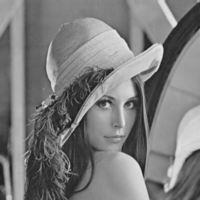

In [32]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

to_tensor = ToTensor()  # img -> tensor
to_pil = ToPILImage()
lena = Image.open("imgs/lena.png")
lena  # 将 lena 可视化输出

torch.Size([1, 200, 200])
Input Size: torch.Size([1, 1, 200, 200])
kernel: tensor([[-0.1111, -0.1111, -0.1111],
        [-0.1111,  1.0000, -0.1111],
        [-0.1111, -0.1111, -0.1111]])
Output Size: torch.Size([1, 1, 198, 198])


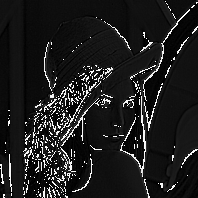

In [33]:
# 输入是一个 batch, batch_size ＝ 1
print(to_tensor(lena).size())
lena = to_tensor(lena).unsqueeze(0)
print("Input Size:", lena.size())  # 查看 input 纬度

# 锐化卷积核
kernel = t.ones(3, 3) / (-9.0)
kernel[1][1] = 1
print("kernel:", kernel)

conv = nn.Conv2d(1, 1, (3, 3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(lena)
print("Output Size:", out.size())
to_pil(out.data.squeeze(0))

在上面的例子中, 输入 Tensor 的大小为 $200\times 200$, 卷积核大小为 $3\times 3$, 步长为 1, 填充为 0, 则根据式(4.1)可以计算得到输出的形状为:

$$
H_{out}=W_{out} = \lfloor {200+{2}\times{0}-3 \over 1 }+1\rfloor=198
$$

这与程序输出的维度一致.

这里我们以二维卷积为例对卷积层的输入输出进行了基本的介绍. 除了二维卷积以外, 图像的卷积操作还有各种变体, 感兴趣的读者可以进一步查阅相关资料.

#### 池化层

池化层可以看作是一种特殊的卷积层, 其主要用于下采样, 增加池化层可以在保留主要特征的同时降低参数量, 从而一定程度上防止了过拟合. 池化层没有可学习参数, 它的 weight 是固定的. 在 `torch.nn` 工具箱中封装好了各种池化层, 常见的有最大池化(MaxPool)和平均池化(AvgPool), 下面将举例说明.

In [34]:
input = t.randint(10, (1, 1, 4, 4))
print(input)
pool = nn.AvgPool2d(
    2, 2
)  # 平均池化, 池化中的卷积核为 2 * 2, 步长默认等于卷积核长度, 无填充
pool(input)

tensor([[[[9, 0, 7, 5],
          [7, 9, 4, 1],
          [1, 8, 3, 7],
          [4, 2, 1, 8]]]])


tensor([[[[6, 4],
          [3, 4]]]])

In [17]:
list(pool.parameters())  # 可以看到, 池化层中并没有可学习参数.

[]

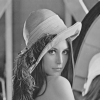

In [35]:
out = pool(lena)
to_pil(out.data.squeeze(0))  # 输出池化后的 lena

In [36]:
input = t.randint(10, (1, 1, 4, 4))
print(input)
pool = nn.MaxPool2d(
    2, 2
)  # 平均池化, 池化中的卷积核为 2 * 2, 步长默认等于卷积核长度, 无填充
pool(input)

tensor([[[[1, 8, 2, 9],
          [5, 4, 5, 6],
          [4, 2, 0, 7],
          [4, 0, 8, 4]]]])


tensor([[[[8, 9],
          [4, 8]]]])

#### 其他层

除了卷积层和池化层, 深度学习中还将常用到以下几个层:

- Linear: 全连接层

- BatchNorm: 批标准化层, 分为 1D、2D 和 3D. 除了标准的 BatchNorm 之外, 还有在风格迁移中常用到的 InstanceNorm 层

- Dropout: Dropout 层, 用来防止过拟合, 同样分为 1D、2D 和 3D.

下面将举几个例子来说明它们的使用方法.

In [37]:
# 输入 batch_size = 2, 维度 3
input = t.randn(2, 3)
print("input:", input)
linear = nn.Linear(3, 4)
h = linear(input)
h

input: tensor([[ 0.3860, -0.5793,  0.0488],
        [ 0.0879,  0.4857,  0.0566]])


tensor([[ 0.5768,  0.2134,  0.1675, -0.4061],
        [ 0.4870,  0.3004,  0.1329, -0.2611]], grad_fn=<AddmmBackward0>)

In [42]:
# 4 channel, 初始化标准差为 4, 均值为 0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
print("bn.weight.data:", bn.weight.data)
bn.bias.data = t.zeros(4)
print("bn.bias.data:", bn.bias.data)
print()

bn_out = bn(h)
print(bn_out)
print(bn_out.size())
print()

# 注意输出的均值和方差
print(bn_out.mean(0))
print()
print(bn_out.std(0, unbiased=False))

bn.weight.data: tensor([4., 4., 4., 4.])
bn.bias.data: tensor([0., 0., 0., 0.])

tensor([[ 3.9901, -3.9895,  3.9346, -3.9962],
        [-3.9901,  3.9895, -3.9345,  3.9962]],
       grad_fn=<NativeBatchNormBackward0>)
torch.Size([2, 4])

tensor([-1.0729e-06,  1.1921e-06,  1.4305e-06,  8.3447e-07],
       grad_fn=<MeanBackward1>)

tensor([3.9901, 3.9895, 3.9345, 3.9962], grad_fn=<StdBackward0>)


In [65]:
# 每个元素以 0.5 的概率随机舍弃
dropout = nn.Dropout(0.5)

print(dropout.training)
o = dropout(bn_out)
print(o)  # 有一半左右的数变为 0

dropout.eval()
print(dropout.training)
o = dropout(bn_out)
print(o)  # 有一半左右的数变为 0

True
tensor([[ 0.0000, -7.9789,  7.8691, -0.0000],
        [-7.9802,  0.0000, -7.8691,  0.0000]], grad_fn=<MulBackward0>)
False
tensor([[ 3.9901, -3.9895,  3.9346, -3.9962],
        [-3.9901,  3.9895, -3.9345,  3.9962]],
       grad_fn=<NativeBatchNormBackward0>)


以上很多例子中都对 module 的属性直接操作, 其大多数是可学习参数, 一般会随着学习的进行而不断改变. 实际使用中除非需要使用特殊的初始化, 否则应尽量不要直接修改这些参数.

### 4.2.2 激活函数

PyTorch 实现了常见的激活函数, 其具体的接口信息可参见官方文档, 这些激活函数可作为独立的 layer 使用. 这里将介绍最常用的激活函数 ReLU, 其数学表达式为:

$$
ReLU(x)=max(0,x) \tag{4.2}
$$

下面来看如何在 `torch.nn` 中使用 ReLU 函数:

In [23]:
relu = nn.ReLU(inplace=True)
input = t.randn(2, 3)
print(input)
output = relu(input)
print(output)  # 小于 0 的都被截断为 0
# 等价于 input.clamp(min=0)

tensor([[ 0.0642,  0.9442, -0.7237],
        [-0.3582, -0.0193,  1.5449]])
tensor([[0.0642, 0.9442, 0.0000],
        [0.0000, 0.0000, 1.5449]])


ReLU 函数有个 inplace 参数, 如果设为 True, 它会把输出直接覆盖到输入中, 这样可以节省内存/显存. 这里之所以可以直接覆盖, 是因为在计算 ReLU 的反向传播时, 只需根据输出就能够推算出反向传播的梯度. 但是只有少数的 autograd 操作支持 inplace 操作(如 tensor.sigmoid_()), 因此除非你明确地知道自己在做什么, 否则一般不要使用 inplace 操作. 除此以外, 常见的激活函数还有 $tanh={{e^x}-{e^{-x}} \over {e^x}+{e^{-x}}}$ 和 $sigmoid={1 \over {1 + {e^{-x}}}}$. 读者可以根据实际的网络结构、数据分布等灵活地选用各类激活函数.

### 4.2.3 构建网络

在以上的例子中, 我们基本上都是将每一层的输出直接作为下一层的输入, 这种网络称为前馈传播网络(Feedforward Neural Network). 对于此类网络如果每次都写复杂的 `forward` 函数会有些麻烦, 这里有两种简化方式: `ModuleList` 和 `Sequential`. 其中 Sequential 是一个特殊的 module, 它包含几个子 Module, 前向传播时会将输入一层接一层的传递下去. ModuleList 也是一个特殊的 Module, 可以包含几个子 module, 我们可以像用 list 一样使用它, 但不能直接把输入传给 ModuleList, 下面将举例说明.

In [45]:
# Sequential 的三种写法
net1 = nn.Sequential()
net1.add_module("conv", nn.Conv2d(3, 3, 3))
net1.add_module("batchnorm", nn.BatchNorm2d(3))
net1.add_module("activation_layer", nn.ReLU())

net2 = nn.Sequential(nn.Conv2d(3, 3, 3), nn.BatchNorm2d(3), nn.ReLU())

from collections import OrderedDict

net3 = nn.Sequential(
    OrderedDict(
        [
            ("conv1", nn.Conv2d(3, 3, 3)),
            ("bn1", nn.BatchNorm2d(3)),
            ("relu1", nn.ReLU()),
        ]
    )
)
print("net1:", net1)
print("net2:", net2)
print("net3:", net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [46]:
print("net1:", net1)
print("net1._parameters:", net1._parameters)
print("net1._modules:", net1._modules)
print("net1._buffers:", net1._buffers)
print("net1._backward_hooks:", net1._backward_hooks)
print("net1._forward_hooks:", net1._forward_hooks)
print("net1.training:", net1.training)
print("net1.__dict__:", net1.__dict__)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net1._parameters: OrderedDict()
net1._modules: OrderedDict([('conv', Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))), ('batchnorm', BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('activation_layer', ReLU())])
net1._buffers: OrderedDict()
net1._backward_hooks: OrderedDict()
net1._forward_hooks: OrderedDict()
net1.training: True
net1.__dict__: {'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': Order

In [47]:
# 可根据名字或序号取出子 module
net1.conv, net2[0], net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [27]:
# 调用已构建的网络
input = t.rand(1, 3, 4, 4)

output = net1(input)
print(output)

output = net2(input)
print(output)

output = net3(input)
print(output)

output = net3.relu1(net1.batchnorm(net1.conv(input)))
print(output)

tensor([[[[0.8842, 0.0000],
          [0.7566, 0.0000]],

         [[0.0000, 0.7076],
          [1.1892, 0.0000]],

         [[1.0496, 0.0000],
          [0.0000, 0.7088]]]], grad_fn=<ReluBackward0>)
tensor([[[[0.0000, 1.6196],
          [0.0000, 0.0000]],

         [[1.3235, 0.0000],
          [0.4016, 0.0000]],

         [[0.6298, 0.6212],
          [0.0000, 0.4763]]]], grad_fn=<ReluBackward0>)
tensor([[[[1.5063, 0.0000],
          [0.0000, 0.2384]],

         [[0.0000, 0.9916],
          [0.2786, 0.3963]],

         [[1.6676, 0.0000],
          [0.0000, 0.0000]]]], grad_fn=<ReluBackward0>)
tensor([[[[0.8842, 0.0000],
          [0.7566, 0.0000]],

         [[0.0000, 0.7076],
          [1.1892, 0.0000]],

         [[1.0496, 0.0000],
          [0.0000, 0.7088]]]], grad_fn=<ReluBackward0>)


In [31]:
modellist = nn.ModuleList([nn.Linear(3, 4), nn.ReLU(), nn.Linear(4, 2)])
input = t.randn(1, 3)
for model in modellist:
    print(input)
    input = model(input)
    print(input)
    print()

# 下面会报错,因为 modellist 没有实现 forward 方法
# output = modelist(input)

tensor([[-0.3506, -0.4682, -1.5710]])
tensor([[-0.8970, -0.7523, -1.1201, -1.1833]], grad_fn=<AddmmBackward0>)

tensor([[-0.8970, -0.7523, -1.1201, -1.1833]], grad_fn=<AddmmBackward0>)
tensor([[0., 0., 0., 0.]], grad_fn=<ReluBackward0>)

tensor([[0., 0., 0., 0.]], grad_fn=<ReluBackward0>)
tensor([[0.4871, 0.1692]], grad_fn=<AddmmBackward0>)



看到这里, 读者可能会问, 为何不直接使用 Python 中自带的 list, 而非要多此一举呢? 这是因为 `ModuleList` 是 `Module` 的子类, 当在 `Module` 中使用它的时候, 就能自动识别为子 module, 下面将举例说明.

In [48]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])

    def forward(self):
        pass


model = MyModule()
print("model:", model)
print("model._parameters:", model._parameters)
print("model._modules:", model._modules)
print("model._buffers:", model._buffers)
print("model._backward_hooks:", model._backward_hooks)
print("model._forward_hooks:", model._forward_hooks)
print("model.training:", model.training)
print("model.__dict__:", model.__dict__)

model: MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)
model._parameters: OrderedDict()
model._modules: OrderedDict([('module_list', ModuleList(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
))])
model._buffers: OrderedDict()
model._backward_hooks: OrderedDict()
model._forward_hooks: OrderedDict()
model.training: True
model.__dict__: {'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pos

In [49]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


可见, list 中的子 module 并不能被主 module 所识别, 而 `ModuleList` 中的子 module 能够被主 module所 识别. 这意味着如果用 list 保存子 module, 将无法调整其参数, 因其未加入到主 module 的参数中.

除了 `ModuleList` 之外还有 `ParameterList`, 它是一个可以包含多个 parameter 的类 list 对象. 在实际应用中, 其使用方式与 `ModuleList` 类似. 如果在构造函数 `__init__` 中用到 list、tuple、dict 等对象时, 一定要思考是否应该用 `ModuleList` 或 `ParameterList` 代替.

### 4.2.3 循环神经网络层(RNN)

近年来, 随着深度学习和自然语言处理领域的逐渐火热, RNN 的使用也越来越多. PyTorch 中实现了如今最常用的三种 RNN: RNN(vanilla RNN)、LSTM 和 GRU. 此外还有对应的三种 RNNCell.

RNN 和 RNNCell 层的区别在于前者一次能够处理整个序列, 而后者一次只处理序列中一个时间点的数据; 同时, RNN 的封装更完备更易于使用, 相比之下 RNNCell 层更具灵活性. 实际上 RNN 层的一种后端实现方式就是调用 RNNCell 来实现的. 下面将举例说明这两种 RNN 层结构.

In [50]:
t.manual_seed(2021)

input = t.randn(2, 3, 4).float()
print("input:", input)

lstm = nn.LSTM(4, 3, 1)

h0 = t.randn(1, 3, 3)
print("h0:", h0)

c0 = t.randn(1, 3, 3)
print("c0:", c0)

out1, hn = lstm(input, (h0, c0))
out1.shape

input: tensor([[[-0.1452,  0.9747,  0.6023,  1.5775],
         [ 0.5700,  0.4273, -0.0021, -1.6452],
         [ 0.4675, -0.2879, -0.0742,  0.1680]],

        [[ 0.6188,  0.7807,  1.5127,  0.9355],
         [-0.8463, -0.0393, -1.9088, -0.3105],
         [ 0.0857,  0.4377,  0.1639,  1.2274]]])
h0: tensor([[[ 0.3641, -0.5107,  2.5208],
         [ 0.5941, -0.6451, -0.1779],
         [-2.1938,  0.5200, -0.0772]]])
c0: tensor([[[-0.6075,  2.4684, -0.5174],
         [ 1.0258, -1.5808, -1.0347],
         [ 0.4003,  1.1366,  0.5626]]])


torch.Size([2, 3, 3])

In [51]:
t.manual_seed(2021)

input = t.randn(2, 3, 4).float()

lstm = nn.LSTMCell(4, 3)
hx = t.randn(3, 3)
cx = t.randn(3, 3)

out = []
for i_ in input:
    hx, cx = lstm(i_, (hx, cx))
    out.append(hx)
out2 = t.stack(out)
out2.shape

torch.Size([2, 3, 3])

其中, 上述两种实现方式下 LSTM 的结果是完全一致的. 读者可以对比一下这两种实现方式有何区别, 并从中体会 RNN 和 RNNCell 层实现的不同.

In [52]:
# 受限于精度问题, 这里使用 allclose 函数说明结果的一致性
out1.allclose(out2)

True

词向量在自然语言中应用十分普及, PyTorch 同样提供了 Embedding 层, 下面将举例说明.

In [57]:
# 有 4 个词, 每个词用 5 维的向量表示
embedding = nn.Embedding(4, 5)

# 可以用预训练好的词向量初始化 embedding
weight = t.arange(0, 20).view(4, 5).float()
embedding.from_pretrained(weight)
embedding.weight.data

tensor([[-1.2042, -1.2447, -1.3487, -0.6362,  0.8926],
        [-0.1286, -1.0406,  0.4500,  0.2018,  0.9161],
        [ 2.4706,  0.8514, -0.7210, -1.2572, -1.1421],
        [ 0.7959, -0.2146, -0.0667,  0.3148, -0.3237]])

In [58]:
input = t.arange(3, 0, -1).long()
print("input:", input)

output = embedding(input)
output

input: tensor([3, 2, 1])


tensor([[ 0.7959, -0.2146, -0.0667,  0.3148, -0.3237],
        [ 2.4706,  0.8514, -0.7210, -1.2572, -1.1421],
        [-0.1286, -1.0406,  0.4500,  0.2018,  0.9161]],
       grad_fn=<EmbeddingBackward0>)

### 4.2.4 损失函数

在深度学习中会经常使用各种各样的损失函数(loss function), 这些损失函数可看作是一种特殊的 layer, PyTorch 也将这些损失函数实现为 `nn.Module` 的子类. 然而在实际使用中通常将这些损失函数专门提取出来, 作为独立的一部分. 详细的 loss 使用请参照官方文档, 这里以分类中最常用的交叉熵损失 CrossEntropyloss 为例进行讲解.

In [59]:
# batch_size = 3, 计算对应每个类别的分数(只有两个类别)
score = t.randn(3, 2)
print("score:", score)

# 三个样本分别属于 1, 0, 1 类, label 必须是 LongTensor
label = t.Tensor([1, 0, 1]).long()
print("label:", label)

# loss 与普通的 layer 无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

score: tensor([[-0.4485, -0.0661],
        [ 0.9854, -2.2637],
        [-0.9039,  0.2389]])
label: tensor([1, 0, 1])


tensor(0.2783)

本小节对 nn 中的常用模块进行了详细的介绍, 利用这些模块读者便可以快速地搭建神经网络. 读者在使用这些模块时应当注意每一个 module 所包含的参数和输入、输出的形状及含义, 从而避免一些不必要的错误.

## 4.3 nn.functional

`torch.nn` 中还有一个很常用的模块: `nn.functional`. `torch.nn` 中的大多数 layer, 在 `functional` 中都有一个与之相对应的函数. `nn.functional` 中的函数和 `nn.Module` 的主要区别在于, 用 `nn.Module` 实现的 layers 是一个特殊的类, 都是由 `class layer(nn.Module)` 定义, 会自动提取可学习的参数; 而 `nn.functional` 中的函数更像是纯函数, 由`def function(input)` 定义. 下面将举例说明 functional 的使用, 并对比二者的不同之处.

### 4.3.1 与 nn.module 的区别

In [60]:
input = t.randn(2, 3)
model = nn.Linear(3, 4)
output1 = model(input)
output2 = nn.functional.linear(input, model.weight, model.bias)
output1 == output2

tensor([[True, True, True, True],
        [True, True, True, True]])

In [61]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

tensor([[True, True, True],
        [True, True, True]])

此时读者可能会问, 应该什么时候使用 `nn.Module`, 什么时候使用 `nn.functional` 呢? 答案很简单, 如果模型有可学习的参数, 最好用 `nn.Module`, 否则既可以使用 `nn.functional` 也可以使用 `nn.Module`, 二者在性能上没有太大差异, 具体的使用取决于个人的喜好. 由于激活函数(`ReLU`、`sigmoid`、`tanh`)、池化(MaxPool)等层没有可学习参数, 可以使用对应的 functional 函数代替; 而卷积、全连接等具有可学习参数的网络建议使用 `nn.Module`. 另外虽然 dropout 操作也没有可学习参数, 但建议还是使用 `nn.Dropout` 而不是 `nn.functional.dropout`, 因为 dropout 在训练和测试两个阶段的行为有所差别, 使用 `nn.Module` 对象能够通过 `model.eval` 操作加以区分. 下面将举例说明如何在模型中搭配使用 `nn.Module` 和 `nn.functional`.

In [66]:
from torch.nn import functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
print("model:", model)
print("model._parameters:", model._parameters)
print("model._modules:", model._modules)
print("model._buffers:", model._buffers)
print("model._backward_hooks:", model._backward_hooks)
print("model._forward_hooks:", model._forward_hooks)
print("model.training:", model.training)
print("model.__dict__:", model.__dict__)

model: Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
model._parameters: OrderedDict()
model._modules: OrderedDict([('conv1', Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))), ('conv2', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))), ('fc1', Linear(in_features=400, out_features=120, bias=True)), ('fc2', Linear(in_features=120, out_features=84, bias=True)), ('fc3', Linear(in_features=84, out_features=10, bias=True))])
model._buffers: OrderedDict()
model._backward_hooks: OrderedDict()
model._forward_hooks: OrderedDict()
model.training: True
model.__dict__: {'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': Ord

对于不具备可学习参数的层(激活层、池化层等), 将它们用函数代替, 这样可以不用放置在构造函数 `__init__` 中. 而对于有可学习参数的模块, 也可以用 functional 代替, 只不过实现起来较为繁琐, 这是因为我们需要手动定义参数 parameter, 如下文自定义实现的全连接层 `MyLinear`, 它需要将 weight 和 bias 两个参数单独拿出来, 在构造函数中初始化为 parameter.

In [69]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))

    def forward(self, input):
        return F.linear(input, weight, bias)


model = MyLinear()
print("model:", model)
print("model._parameters:", model._parameters)
print("model._modules:", model._modules)
print("model._buffers:", model._buffers)
print("model._backward_hooks:", model._backward_hooks)
print("model._forward_hooks:", model._forward_hooks)
print("model.training:", model.training)
print("model.__dict__:", model.__dict__)

model: MyLinear()
model._parameters: OrderedDict([('weight', Parameter containing:
tensor([[-0.5944,  1.3759, -0.1351, -0.0746],
        [ 0.5213, -0.1982, -0.8121,  0.9569],
        [-0.7358, -0.5140,  0.2562, -0.0492]], requires_grad=True)), ('bias', Parameter containing:
tensor([0., 0., 0.], requires_grad=True))])
model._modules: OrderedDict()
model._buffers: OrderedDict()
model._backward_hooks: OrderedDict()
model._forward_hooks: OrderedDict()
model.training: True
model.__dict__: {'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.5944,  1.3759, -0.1351, -0.0746],
        [ 0.5213, -0.1982, -0.8121,  0.9569],
        [-0.7358, -0.5140,  0.2562, -0.0492]], requires_grad=True)), ('bias', Parameter containing:
tensor([0., 0., 0.], requires_grad=True))]), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': Ordered

关于 nn.functional 的设计初衷, 以及它和 nn.Module 更多的比较说明, 读者可参看 PyTorch 中论坛的相关讨论和说明.

### 4.3.2 采样函数

在 `nn.functional` 中还有一个常用的函数: 采样函数 `torch.nn.functional.grid_sample`, 它的主要作用是对输入的 Tensor 进行双线性采样, 并让输出变换为我们想要的形状. 这里我们用 lena 来进行举例说明.

tensor([[[[0.6353, 0.6314, 0.6314,  ..., 0.6118, 0.6667, 0.5922],
          [0.6353, 0.6314, 0.6314,  ..., 0.6078, 0.6510, 0.5647],
          [0.6275, 0.6235, 0.6235,  ..., 0.4824, 0.4157, 0.3098],
          ...,
          [0.1961, 0.2078, 0.2078,  ..., 0.2510, 0.3098, 0.3412],
          [0.1922, 0.2000, 0.2039,  ..., 0.3098, 0.3686, 0.3804],
          [0.1843, 0.2078, 0.1961,  ..., 0.3569, 0.3961, 0.4078]]]])
torch.Size([1, 1, 200, 200])
tensor([[[[0.6353, 0.6314, 0.6314,  ..., 0.6118, 0.6667, 0.5922],
          [0.6353, 0.6314, 0.6314,  ..., 0.6078, 0.6510, 0.5647],
          [0.6275, 0.6235, 0.6235,  ..., 0.4824, 0.4157, 0.3098],
          ...,
          [0.1961, 0.2078, 0.2078,  ..., 0.2510, 0.3098, 0.3412],
          [0.1922, 0.2000, 0.2039,  ..., 0.3098, 0.3686, 0.3804],
          [0.1843, 0.2078, 0.1961,  ..., 0.3569, 0.3961, 0.4078]]]])
torch.Size([1, 1, 200, 200])
tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
      

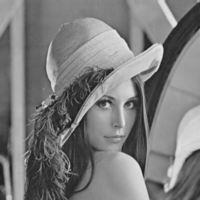

In [75]:
print(lena)
print(lena.size())
print(lena.data)
print(lena.data.size())
print(lena == lena.data)
print(lena.data.squeeze(0).size())
to_pil(lena.data.squeeze(0))  # 原始的 lena 数据

In [76]:
# lena 的形状是 1 x 1 x 200 x 200, (N, C, Hin, Win)
w = 400  # 准备将图像放大至 400
# 得到 400 x 400 的介于 [-1, 1] 之间的均匀分布张量
h_out = t.linspace(-1, 1, w).view(-1, 1).repeat(1, w)
w_out = t.linspace(-1, 1, w).repeat(w, 1)

grid = t.cat((w_out.unsqueeze(2), h_out.unsqueeze(2)), dim=2)

# grid 形状为 (N, Hout, Wout, 2)
# grid 最后一个维度大小为 2, 表示输入中 pixel 的位置信息, 取值范围在 (-1, 1)
grid = grid.unsqueeze(0)

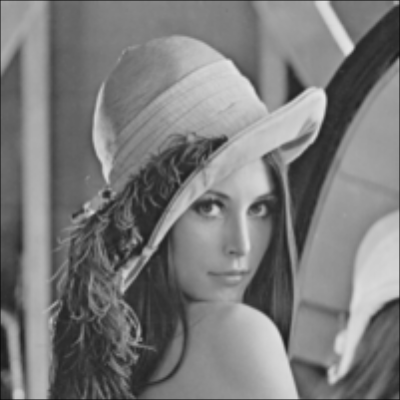

In [78]:
import torch
from torch.nn import functional as F
import warnings

warnings.filterwarnings("ignore")

out = F.grid_sample(lena, grid=grid, mode="bilinear")
to_pil(out.data.squeeze(0))

## 4.4 初始化策略

在深度学习中参数的初始化十分重要, 良好的初始化能让模型更快地收敛, 并达到更高水平, 而糟糕的初始化则可能使得模型迅速崩溃. PyTorch 中 `nn.Module` 的模块参数都采取了较为合理的初始化策略, 因此一般不用我们考虑. 当然我们也可以用自定义初始化来代替系统的默认初始化. 而当我们在使用 Parameter 时, 自定义初始化则尤为重要, 这是因为 torch.Tensor() 返回的是内存中的随机数, 很可能会有极大值, 这在实际训练网络中会造成溢出或者梯度消失. PyTorch 中 `nn.init` 模块就是专门为初始化而设计的一个模块, 其中实现了常用的初始化策略. 如果某种初始化策略 `nn.init` 不提供, 用户也可以自己直接初始化.

In [83]:
# 利用 nn.init 初始化
from torch.nn import init

linear = nn.Linear(3, 4)
print(linear.weight)

t.manual_seed(2021)

init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[-0.1462, -0.5296,  0.3911],
        [-0.5076, -0.3727, -0.1962],
        [ 0.2145,  0.2263,  0.3814],
        [ 0.0249,  0.2815,  0.3798]], requires_grad=True)


Parameter containing:
tensor([[ 1.2225,  0.3428, -0.4605],
        [-0.1951, -0.3705,  0.4823],
        [-1.4530, -0.7739,  0.3334],
        [ 0.2577, -1.2324,  0.4905]], requires_grad=True)

In [84]:
# 利用公式, 直接初始化
import math

t.manual_seed(2021)

# xavier 初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.0)
linear.weight.data.normal_(0, std)

tensor([[ 1.2225,  0.3428, -0.4605],
        [-0.1951, -0.3705,  0.4823],
        [-1.4530, -0.7739,  0.3334],
        [ 0.2577, -1.2324,  0.4905]])

In [85]:
# 对模型的所有参数进行初始化
net = Net()
for name, params in net.named_parameters():
    if name.find("linear") != -1:
        # init linear
        params[0]  # weight
        params[1]  # bias
    elif name.find("conv") != -1:
        pass
    elif name.find("norm") != -1:
        pass

## 4.5 优化器

PyTorch 将深度学习中常用的优化方法全部封装在 `torch.optim` 中, 其设计十分灵活, 能够很方便地扩展成自定义的优化方法.

所有的优化方法都是继承基类 `optim.Optimizer`, 并实现了自己的优化步骤. 下面就以最基本的优化方法——随机梯度下降法(SGD)举例说明. 这里需要重点掌握:

1. 优化方法的基本使用方法

2. 如何对模型的不同部分设置不同的学习率

3. 如何调整学习率.

In [91]:
# 以本章 4.1 节的感知器为例
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Perceptron, self).__init__()
        # 此处的 Linear 是前面自定义的全连接层
        self.layer1 = Linear(in_features, hidden_features)
        self.layer2 = Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)


net = Perceptron(3, 4, 1)

for name, param in net.named_parameters():
    print(name, param)

layer1.w Parameter containing:
tensor([[ 0.3442,  0.0862, -1.0815, -1.4642],
        [-0.9875, -0.6719,  1.3694,  1.1286],
        [-1.3007, -0.2235,  0.3119, -1.0006]], requires_grad=True)
layer1.b Parameter containing:
tensor([-0.7277,  0.2880,  0.3517,  1.1309], requires_grad=True)
layer2.w Parameter containing:
tensor([[ 0.6224],
        [-0.8230],
        [ 2.5361],
        [ 0.4888]], requires_grad=True)
layer2.b Parameter containing:
tensor([-0.7849], requires_grad=True)


In [92]:
from torch import optim

optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad()  # 梯度清零, 等价于 net.zero_grad()

input = t.randn(32, 3)
output = net(input)
output.backward(output)  # fake backward

optimizer.step()  # 执行优化
for name, param in net.named_parameters():
    print(name, param)

layer1.w Parameter containing:
tensor([[ 1.4052, -3.3755,  1.6308, -0.9749],
        [-2.0446,  2.2990, -1.3834,  0.5876],
        [-0.6564,  0.8133,  0.9629, -1.8090]], requires_grad=True)
layer1.b Parameter containing:
tensor([-2.5167,  4.8613, -8.5671,  0.1335], requires_grad=True)
layer2.w Parameter containing:
tensor([[ -3.7034],
        [-10.8462],
        [-17.8969],
        [-21.1537]], requires_grad=True)
layer2.b Parameter containing:
tensor([-24.4299], requires_grad=True)


In [93]:
# 对模型的不同部分设置不同的学习率
weight_params = [param for name, param in net.named_parameters() if name.endswith(".w")]
bias_params = [param for name, param in net.named_parameters() if name.endswith(".b")]

optimizer = optim.SGD(
    [{"params": bias_params}, {"params": weight_params, "lr": 1e-2}], lr=1e-5
)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [94]:
# 只为第一个全连接层设置较大的学习率, 其余层的学习率较小
special_layers = nn.ModuleList([net.layer1])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = [
    param for param in net.parameters() if id(param) not in special_layers_params
]
optimizer = t.optim.SGD(
    [{"params": base_params}, {"params": special_layers.parameters(), "lr": 0.01}],
    lr=0.001,
)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

调整学习率主要有两种做法:

1. 修改 optimizer.param_groups 中对应的学习率

2. 新建一个优化器.

相比之下笔者更加推荐第二种做法, 这是因为 optimizer 一般构建开销很小, 故而可以构建新的 optimizer. 但是新建优化器会重新初始化动量等状态信息, 这对于使用动量的优化器(如Adam), 可能会造成损失函数在收敛过程中出现震荡等情况.

In [95]:
# 调整学习率, 新建一个 optimizer
old_lr = 0.1
optimizer1 = optim.SGD(
    [{"params": bias_params}, {"params": weight_params, "lr": old_lr * 0.1}], lr=1e-5
)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.010000000000000002
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [57]:
# 调整学习率, 手动 decay, 保存动量
for param_group in optimizer.param_groups:
    param_group["lr"] *= 0.1  # 学习率为之前的 0.1 倍
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## 4.6 nn.Module 深入分析

如果想要更深入地理解 nn.Module, 研究其原理是很有必要的. 首先来看看 nn.Module 基类的构造函数:

```python
def __init__(self):
    self._parameters = OrderedDict()
    self._modules = OrderedDict()
    self._buffers = OrderedDict()
    self._backward_hooks = OrderedDict()
    self._forward_hooks = OrderedDict()
    self.training = True
    # python 默认还有一个 __dict__ 属性
```

其中:

- `_parameters`: 字典, 保存用户直接设置的 parameter. 例如 `self.param1 = nn.Parameter(t.randn(3, 3))` 会被检测到, 在字典中加入一个 key 为 param, value 为对应 parameter 的 item. 而 self.submodule = nn.Linear(3, 4) 中的 parameter 则不会存于此

- `_modules`: 子 module, 例如通过 `self.submodel = nn.Linear(3, 4)` 指定的子 module 会保存于此

- `_buffers`: 缓存. 例如 BatchNorm 使用 Momentum 机制, 每次前向传播需用到上一次前向传播的结果

- `_backward_hooks` 与 `_forward_hooks`: 钩子技术, 用来提取中间变量

- `training`: BatchNorm 与 Dropout 层在训练阶段和测试阶段中采取的策略不同, 通过判断 training 值来决定前向传播策略.

上述几个属性中, `_parameters`、`_modules` 和 `_buffers` 这三个字典中的键值, 都可以通过 `self.key` 方式获得, 效果等价于 `self._parameters['key']`, 下面将举例说明.

In [96]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 等价与 self.register_parameter('param1' ,nn.Parameter(t.randn(3, 3)))
        self.param1 = nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4)

    def forward(self, input):
        x = self.param1.mm(input)
        x = self.submodel1(x)
        return x


net = Net()
print("net:", net)
print("net._parameters:", net._parameters)
print("net._modules:", net._modules)
print("net._buffers:", net._buffers)
print("net._backward_hooks:", net._backward_hooks)
print("net._forward_hooks:", net._forward_hooks)
print("net.training:", net.training)
print("net.__dict__:", net.__dict__)
print()
print("net.submodel1._parameters:", net.submodel1._parameters)
print("net.submodel1._modules:", net.submodel1._modules)
print("net.submodel1._buffers:", net.submodel1._buffers)
print("net.submodel1._backward_hooks:", net.submodel1._backward_hooks)
print("net.submodel1._forward_hooks:", net.submodel1._forward_hooks)
print("net.submodel1.training:", net.submodel1.training)
print("net.submodel1.__dict__:", net.submodel1.__dict__)

net: Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
net._parameters: OrderedDict([('param1', Parameter containing:
tensor([[0.8919, 0.3783, 0.2719],
        [0.6543, 0.3218, 0.6907],
        [0.5306, 0.3943, 0.8600]], requires_grad=True))])
net._modules: OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])
net._buffers: OrderedDict()
net._backward_hooks: OrderedDict()
net._forward_hooks: OrderedDict()
net.training: True
net.__dict__: {'training': True, '_parameters': OrderedDict([('param1', Parameter containing:
tensor([[0.8919, 0.3783, 0.2719],
        [0.6543, 0.3218, 0.6907],
        [0.5306, 0.3943, 0.8600]], requires_grad=True))]), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_p

In [97]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [98]:
net._parameters

OrderedDict([('param1',
              Parameter containing:
              tensor([[0.8919, 0.3783, 0.2719],
                      [0.6543, 0.3218, 0.6907],
                      [0.5306, 0.3943, 0.8600]], requires_grad=True))])

In [99]:
net.param1  # 等价于 net._parameters['param1']

Parameter containing:
tensor([[0.8919, 0.3783, 0.2719],
        [0.6543, 0.3218, 0.6907],
        [0.5306, 0.3943, 0.8600]], requires_grad=True)

In [100]:
net.submodel1

Linear(in_features=3, out_features=4, bias=True)

In [101]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [102]:
for name, submodel in net.named_modules():
    print(name, submodel)  # 当前 module 和他的子 module

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [103]:
bn = nn.BatchNorm1d(2)
input = t.rand(3, 2)
output = bn(input)
print("bn._parameters:", bn._parameters)
print("bn._modules:", bn._modules)
print("bn._buffers:", bn._buffers)
print("bn._backward_hooks:", bn._backward_hooks)
print("bn._forward_hooks:", bn._forward_hooks)
print("bn.training:", bn.training)
print("bn.__dict__:", bn.__dict__)

bn._parameters: OrderedDict([('weight', Parameter containing:
tensor([1., 1.], requires_grad=True)), ('bias', Parameter containing:
tensor([0., 0.], requires_grad=True))])
bn._modules: OrderedDict()
bn._buffers: OrderedDict([('running_mean', tensor([0.0626, 0.0458])), ('running_var', tensor([0.9001, 0.9021])), ('num_batches_tracked', tensor(1))])
bn._backward_hooks: OrderedDict()
bn._forward_hooks: OrderedDict()
bn.training: True
bn.__dict__: {'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([1., 1.], requires_grad=True)), ('bias', Parameter containing:
tensor([0., 0.], requires_grad=True))]), '_buffers': OrderedDict([('running_mean', tensor([0.0626, 0.0458])), ('running_var', tensor([0.9001, 0.9021])), ('num_batches_tracked', tensor(1))]), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': Ordered

从上面的示例中可以看出, `nn.Module` 在实际使用中可能层层嵌套: 一个 module 包含若干个子 module, 每一个子 module 又包含了更多的子 module. 为方便用户访问各个子 module, `nn.Module` 实现了很多方法, 如函数 `children` 可以查看直接子 module, 函数 `modules` 可以查看所有的子 module(包括当前 module). 与之相对应的还有函数 `named_childen` 和 `named_modules`, 其能够在返回 module 列表的同时返回它们的名字.

In [104]:
input = t.arange(0, 12).view(3, 4).float()
model = nn.Dropout()
print("model._parameters:", model._parameters)
print("model._modules:", model._modules)
print("model._buffers:", model._buffers)
print("model._backward_hooks:", model._backward_hooks)
print("model._forward_hooks:", model._forward_hooks)
print("model.training:", model.training)
print("model.__dict__:", model.__dict__)
# 在训练阶段, 会有一半左右的数被随机置为 0
print(model(input))

model._parameters: OrderedDict()
model._modules: OrderedDict()
model._buffers: OrderedDict()
model._backward_hooks: OrderedDict()
model._forward_hooks: OrderedDict()
model.training: True
model.__dict__: {'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict(), 'p': 0.5, 'inplace': False}
tensor([[ 0.,  0.,  0.,  0.],
        [ 8.,  0.,  0.,  0.],
        [16., 18., 20.,  0.]])


In [105]:
model.training = False
print("model._parameters:", model._parameters)
print("model._modules:", model._modules)
print("model._buffers:", model._buffers)
print("model._backward_hooks:", model._backward_hooks)
print("model._forward_hooks:", model._forward_hooks)
print("model.training:", model.training)
print("model.__dict__:", model.__dict__)
# 在测试阶段, dropout 什么都不做
print(model(input))

model._parameters: OrderedDict()
model._modules: OrderedDict()
model._buffers: OrderedDict()
model._backward_hooks: OrderedDict()
model._forward_hooks: OrderedDict()
model.training: False
model.__dict__: {'training': False, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict(), 'p': 0.5, 'inplace': False}
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])


对于 BatchNorm、Dropout、InstanceNorm 等在训练和测试阶段行为差距较大的层, 如果在测试时不将其 training 值设为 False, 则可能会有很大影响, 这在实际使用中要格外注意. 虽然可以通过直接设置 `training` 属性来将子 module 设为 train 和 eval 模式, 但这种方式较为繁琐. 因为, 如果一个模型具有多个 Dropout 层, 就需要为每个 Dropout 层指定 training 属性. 笔者推荐的做法是调用 `model.train()` 函数, 它会将当前 module 及其子 module 中的所有 training 属性都设为True, 相应地, `model.eval()` 函数会把 training 属性都设为 False.

In [106]:
net.training, net.submodel1.training

(True, True)

In [107]:
net.eval()  # eval() 将所有的 training 属性设为 False
net.training, net.submodel1.training

(False, False)

In [69]:
list(net.named_modules())

[('',
  Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )),
 ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

`register_forward_hook` 和 `register_backward_hook` 函数可以在 module 前向传播或反向传播时注册钩子. 每次前向传播执行结束后会执行钩子函数(hook). 前向传播的钩子函数具有如下形式: `hook(module, input, output) -> None`, 而反向传播则具有如下形式: `hook(module, grad_input, grad_output) -> Tensor or None`. 钩子函数不应修改输入和输出, 并且在使用后应及时删除, 以避免每次都运行钩子增加运行负载. 钩子函数主要用在获取某些中间结果的情景, 如中间某一层的输出或某一层的梯度. 这些结果本应写在 forward 函数中, 但如果在 forward 函数中专门加上这些处理, 可能会使处理逻辑比较复杂, 这时候使用钩子技术就更加合适. 下面考虑一种场景, 有一个预训练好的模型, 需要提取模型的某一层(不是最后一层)的输出作为特征进行分类, 但又不希望修改其原有的模型定义文件, 这时就可以利用钩子函数. 下面给出实现的伪代码.

```python
model = VGG()
features = t.Tensor()
def hook(module, input, output):
    '''把这层的输出拷贝到 features 中 '''
    features.copy_(output.data)

handle = model.layer8.register_forward_hook(hook)
_ = model(input)
# 用完 hook 后删除
handle.remove()
```

`nn.Module` 对象在构造函数中的行为看起来有些怪异, 如果想要真正掌握其原理, 就需要看两个魔法方法 `__getattr__` 和 `__setattr__`. 在 Python 中有两个常用的 buildin 方法 `getattr` 和 `setattr`.

1. 对于 `getattr(obj, 'attr1')`, 其等价于 `obj.attr`, 如果 `getattr` 函数无法找到所需属性, Python 会调用 `obj.__getattr__('attr1')` 方法, 即 `getattr` 函数无法找到的交给 `__getattr__` 函数处理; 如果这个对象没有实现 `__getattr__` 方法, 或者遇到 `__getattr__` 方法也无法处理情况, 程序就会抛出异常 AttributeError.

2. 对于 `setattr(obj, 'name', value)`, 其等价于 `obj.name=value`, 如果 obj 对象实现了 `__setattr__` 方法, `setattr` 会直接调用 `obj.__setattr__('name', value)`, 否则调用 buildin 方法.

总结如下:

- result  = obj.name 会调用 buildin 函数 `getattr(obj, 'name')`, 如果该属性找不到, 则会调用 `obj.__getattr__('name')`

- obj.name = value 会调用 buildin 函数 `setattr(obj, 'name', value)`, 如果 obj 对象实现了 `__setattr__` 方法, `setattr` 会直接调用 `obj.__setattr__('name', value)`

nn.Module 实现了自定义的 `__setattr__` 函数, 当执行 `module.name=value`时 , 会在 `__setattr__` 中判断 value 是否为 `Parameter` 或 `nn.Module` 对象, 如果是则将这些对象加到 `_parameters` 和 `_modules` 两个字典中; 而如果是其它类型的对象, 如 `list`、`dict` 等, 则调用默认的操作, 将这个值保存在 `__dict__` 中.

In [70]:
module = nn.Module()
module.param = nn.Parameter(t.ones(2, 2))
module._parameters

OrderedDict([('param',
              Parameter containing:
              tensor([[1., 1.],
                      [1., 1.]], requires_grad=True))])

In [71]:
submodule1 = nn.Linear(2, 2)
submodule2 = nn.Linear(2, 2)
module_list = [submodule1, submodule2]
# 对于 list 对象, 调用 buildin 函数, 保存在 __dict__ 中
module.submodules = module_list
print("_modules: ", module._modules)
print("__dict__['submodules']:", module.__dict__.get("submodules"))

_modules:  OrderedDict()
__dict__['submodules']: [Linear(in_features=2, out_features=2, bias=True), Linear(in_features=2, out_features=2, bias=True)]


In [72]:
module_list = nn.ModuleList(module_list)
module.submodules = module_list
print("ModuleList is instance of nn.Module: ", isinstance(module_list, nn.Module))
print("_modules: ", module._modules)
print("__dict__['submodules']:", module.__dict__.get("submodules"))

ModuleList is instance of nn.Module:  True
_modules:  OrderedDict([('submodules', ModuleList(
  (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
))])
__dict__['submodules']: None


因 `_modules` 和 `_parameters` 中的 item 未保存在 `__dict__` 中, 所以默认的 `getattr` 方法无法获取它, 因而 `nn.Module` 实现了自定义的 `__getattr__` 方法. 如果默认的 `getattr` 无法处理, 就调用自定义的 `__getattr__` 方法, 尝试从 `_modules`、`_parameters` 和 `_buffers` 这三个字典中获取.

In [73]:
getattr(module, "training")  # 等价于 module.training
# error
# module.__getattr__('training')

True

In [74]:
module.attr1 = 2
getattr(module, "attr1")
# 报错
# module.__getattr__('attr1')

2

In [75]:
# 即 module.param, 会调用 module.__getattr__('param')
getattr(module, "param")

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

在 PyTorch 中保存模型十分简单, 所有的 Module 对象都具有 state_dict() 函数, 返回当前 Module 所有的状态数据. 将这些状态数据保存后, 下次使用模型时即可利用 `model.load_state_dict()` 函数将状态加载进来. 优化器(optimizer)也有类似的机制, 不过一般并不需要保存优化器的运行状态.

In [76]:
# 保存模型
t.save(net.state_dict(), "net.pth")

# 加载已保存的模型
net2 = Net()
net2.load_state_dict(t.load("net.pth"))

<All keys matched successfully>

实际上还有另外一种保存方法, 但因其严重依赖模型定义方式及文件路径结构等, 很容易出问题, 因而不建议使用.

In [77]:
t.save(net, "net_all.pth")
net2 = t.load("net_all.pth")
net2

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

将 Module 放在 GPU 上运行也十分简单, 只需以下两步:

- model = model.cuda(): 将模型的所有参数转存到 GPU

- input.cuda(): 将输入数据放置到 GPU 上.

至于如何在多个 GPU 上并行计算, PyTorch 也提供了两个函数, 可实现简单高效的并行 GPU 计算.

- nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)

- class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

可见二者的参数十分相似, 通过 `device_ids` 参数可以指定在哪些 GPU 上进行优化, 而通过 `output_device` 参数可以指定输出到哪个 GPU 上. 二者唯一的不同就在于前者直接利用多 GPU 并行计算得出结果, 而后者则返回一个新的 module, 能够自动在多 GPU 上进行并行加速.

```
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

DataParallel 并行的方式, 是将输入一个 batch 的数据均分成多份, 分别送到对应的 GPU 进行计算, 各个 GPU 得到的梯度累加. 与 Module 相关的所有数据也都会以浅复制的方式复制多份.

## 4.7 小试牛刀: 搭建 ResNet

Kaiming He 提出的深度残差网络(ResNet)在深度学习的发展中起到了很重要的作用, ResNet 不仅一举拿下了当年多个计算机视觉比赛项目的冠军, 更重要的是这一结构解决了训练极深网络时的梯度消失问题.

这里选取的是 ResNet 的一个变种 ResNet34 来讲解 ResNet 的网络结构. ResNet 的网络结构如图 4-2 所示, 除了最开始的卷积池化和最后的池化全连接之外, 网络中有很多结构相似的单元, 这些重复单元的共同点就是有个跨层直连的 shortcut. ResNet 中将一个跨层直连的单元称为 Residual Block, 其结构如图 4-3 所示, 左边部分是普通的卷积网络结构, 右边是直连, 但如果输入和输出的通道数不一致, 或其步长不为 1, 那么就需要有一个专门的单元将二者转成一致, 使其可以相加.

另外我们可以发现 Residual Block 的大小也是有规律的, 在最开始的 pool 之后有连续的几个一模一样的 Residual Block 单元, 这些单元的通道数一样, 在这里我们将这几个拥有多个 Residual Block 单元的结构称之为 layer. 读者需要将这里的 layer 和之前讲的 layer 区分开来, 这里的 layer 是几个层的集合.

考虑到 Residual Block 和 layer 出现了多次, 我们可以把它们实现为一个子 Module 或函数. 这里我们将 Residual Block 实现为一个子 module, 而将 layer 实现为一个函数. 下面是实现代码, 规律总结如下:

- 对于模型中的重复部分, 实现为子 module 或用函数生成相应的 module

- nn.Module 和 nn.Functional 结合使用

- 尽量使用 `nn.Seqential`.

![图4-2: ResNet34网络结构](imgs/resnet1.png)

![图4-3: Residual block 结构图](imgs/residual.png)


In [78]:
from torch import nn
import torch as t
from torch.nn import functional as F

In [80]:
class ResidualBlock(nn.Module):
    """
    实现子 module: Residual Block
    """

    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outchannel),
        )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)


class ResNet(nn.Module):
    """
    实现主 module: ResNet34
    ResNet34 包含多个 layer, 每个 layer 又包含多个 residual block
    用子 module 来实现 residual block, 用 _make_layer 函数来实现 layer
    """

    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
        )

        # 重复的 layer, 分别有 3, 4, 6, 3 个 Residual Block
        self.layer1 = self._make_layer(64, 64, 3, 1, is_shortcut=False)
        self.layer2 = self._make_layer(64, 128, 4, 2)
        self.layer3 = self._make_layer(128, 256, 6, 2)
        self.layer4 = self._make_layer(256, 512, 3, 2)

        # 分类用的全连接
        self.classifier = nn.Linear(512, num_classes)

    def _make_layer(self, inchannel, outchannel, block_num, stride, is_shortcut=True):
        """
        构建 layer, 包含多个 residual block
        """
        if is_shortcut:
            shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, 1, stride, bias=False),
                nn.BatchNorm2d(outchannel),
            )
        else:
            shortcut = None

        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))

        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [81]:
model = ResNet()
input = t.randn(1, 3, 224, 224)
out = model(input)

感兴趣的读者可以尝试实现一下 Google 的 Inception 网络结构或 ResNet 的其它变体, 看看如何能够简洁明了地实现这些经典的网络结构. 另外, 与 PyTorch 配套的图像工具包 `torchvision` 已经实现了深度学习中大多数经典的模型, 其中就包括 ResNet34, 读者可以通过下面两行代码使用:

```python
from torchvision import models
model = models.resnet34()
```

关于 `torchvision` 的具体内容将在本书第五章进行讲解, 通过 torchvision 我们便可以方便地使用深度学习中经典的网络模型了.

## 本章小结

本章详细介绍了神经网络工具箱 nn 的使用. 首先本章对神经网络中常用层结构进行了介绍, 并举例说明了如何使用 `nn.Module` 模块来实现这些常用的层结构; 其次, 本章对 `nn.Module` 进行了深入剖析, 并详细介绍了其构造函数与两种魔法方法; 同时, 本章还对神经网络中的初始化策略与优化器进行了详细讲解; 最后, 本章运用 `nn.Module` 模块实现了经典的 ResNet 网络结构. 通过本章的学习, 读者可以掌握神经网络工具箱中大部分类和函数的用法, 并按照实际需要搭建自己的网络结构.